# 1. Regresión

Revisaremos los conceptos de regresión vistos en el teórico.

Haremos pruebas con datos de entrada de **una dimensión**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Función Verdadera Oculta

Usaremos como función oculta un sinusoide.

In [6]:
def create_sinusoidal_data(spread=0.25, data_size=50):
    np.random.seed(0)
    # obtenemos los puntos x con la funcion linspace
    x = np.linspace(0, 1, data_size)
    y = np.sin(2 * np.pi * x) + np.random.normal(scale=spread, size=x.shape) #con esto agregamos un poco de ruido aleatorio.

    return x, y

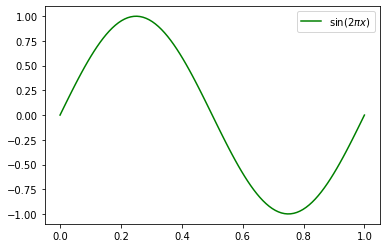

In [11]:
x, f_x = create_sinusoidal_data(0, 100)
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

## Muestra Ruidosa

Tomaremos puntos uniformes en $x$, ruidosos en $y$.

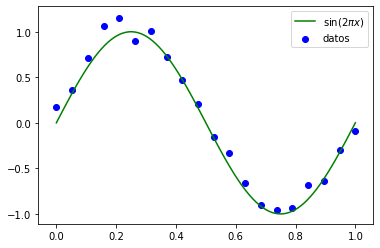

In [15]:
data_size = 20
X, y = create_sinusoidal_data(0.1, data_size)

plt.scatter(X, y, color="blue", label="datos")
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

## División en Entrenamiento y Evaluación

Dividiremos aleatoriamente los datos en una parte para entrenamiento y otra para evaluación.

Usaremos 
[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) de scikit-learn:

In [25]:
# X, X.shape, y.shape

In [26]:
from sklearn.model_selection import train_test_split

train_size = 5 #si pongo un valor entre 0 y 1, es una proporcion, 0.8 seria el 80 %
test_size = data_size - train_size
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)

In [28]:
#Dividimos el vector en 2 nuevos vectores de 15 y 5 elementos.
X_train.shape, X_test.shape 

((5,), (15,))

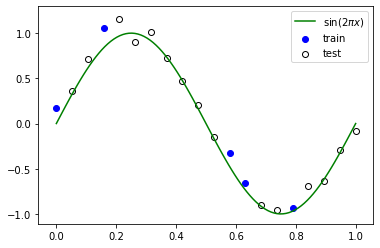

In [29]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

## Regresión Lineal

Probaremos ajustar los puntos usando una recta.

Vamos a programar a mano el aprendizaje y la predicción.

### Solución de Cuadrados Mínimos

Datos de entrenamiento:
- $X \in R^{N \times K}:$ $N$ vectores de entrada, de $K$ dimensiones cada uno.
- $y \in R^N:$ $N$ valores de salida.

Aprendizaje:

$$w^* = (X^\top X)^{-1} X^\top y$$

Predicción:

$$f_{w^*}(x) = x^\top w^* = \sum_{k=1}^K x_k w^*_k$$

Con $K=1$ tendríamos:

$$f_{w^*}(x) = x_1 w_1^*$$

Para que sea una recta nos falta un $w_0$ ("bias").
Esto se puede resolver haciendo $K=2$ y agregando un valor constante 1 a cada dato:

$$f_{w^*}((1, x)) = w_0 + x_1 w_1^*$$


In [30]:
def linear_least_squares(X, y):
    X_b = np.stack((X, np.ones(X.shape[0])), axis=1)  # add bias
    return np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T.dot(y))

def f(X, w):
    X_b = np.stack((X, np.ones(X.shape[0])), axis=1)  # add bias: (1, x)
    return X_b.dot(w)

### Entrenar

In [31]:
X_train, y_train

(array([0.57894737, 0.15789474, 0.        , 0.78947368, 0.63157895]),
 array([-0.33052004,  1.0612558 ,  0.17640523, -0.93603283, -0.65962014]))

In [32]:
w = linear_least_squares(X_train, y_train)

In [34]:
w  # una recta! 
# que dimension tiene w? 2

array([-1.95626346,  0.70657973])

### Graficar

Graficaremos la función aprendida a partir de los datos de entrenamiento. También graficaremos con los datos de evaluación y la función oculta, para comparar.

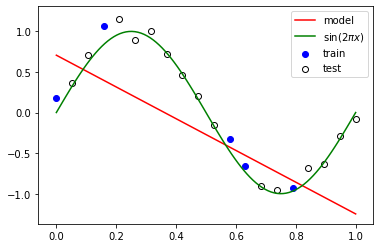

In [37]:
plt.scatter(X_train, y_train, color="blue", label="train") #imprime puntos de entrenamiento
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test") #imprime puntos de test
plt.plot(x, f(x, w), color="red", label="model") #linea recta de nuestro modelo que acabo de aprender.
# llamo muchas veces a la funcion f con el vector w que acabo de aprender?? 

plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

### Predecir y Evaluar: Error Cuadrático Medio

Obtendremos los valores predichos para los datos de entrenamiento y de evaluación.
Calcularemos el error cuadrático medio sobre ambos conjuntos de datos.

In [38]:
y_train_pred = f(X_train, w)
y_test_pred = f(X_test, w)

Usamos la función [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) de scikit-learn:

In [39]:
from sklearn.metrics import mean_squared_error

train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)
print(f'Train error: {train_error:0.2}')
print(f'Test error: {test_error:0.2}')

Train error: 0.15
Test error: 0.38


## Regresión Polinomial

Ahora haremos regresión polinomial. En este caso usaremos scikit-learn para definir el modelo, entrenar y predecir.

En scikit-learn cada dato de entrada debe ser un vector, no un número. Debemos convertir cada dato en un vector de una dimensión:

In [40]:
X_train.shape, X_test.shape

((5,), (15,))

In [43]:
# Para que scikit-learn los entienda bien, tengo que convertir los vectores a matrices (reshape)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
X_train.shape, X_test.shape

((5, 1), (15, 1))

### Instanciar y Entrenar

En scikit-learn, la regresión polinomial se implementa como un modelo de dos pasos (ver [Polynomial interpolation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html)).

Crearemos y entrenaremos un modelo de grado 2.

Como siempre en scikit-learn, para entrenar usamos la función **fit**.

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures # se encarga de la transformacion de los datos de entrada, es un modulo que hace un preprocesamiento de los datos
from sklearn.pipeline import make_pipeline # una secuenciacion de la transformacion para pasarlo como entrada de una regresion lineal.

degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

**NOTA:** **test** se utiliza solo como ejemplo para mostrar como se hace la transformacion. 

In [59]:
test = PolynomialFeatures(degree)
test.fit(X_train, y_train)

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [60]:
test2 = test.transform(X_train)

In [61]:
test2.shape

(5, 3)

Cuando hace la transformacion, lo que hace es que por cada dato del vector X_train lo transforma en un vector de 3 componentes.
$$(X)^{0}, (X)^{1}, (X)^{2}$$

In [62]:
X_train[0], test2[0]

(array([0.57894737]), array([1.        , 0.57894737, 0.33518006]))

In [63]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

### Graficar Resultado

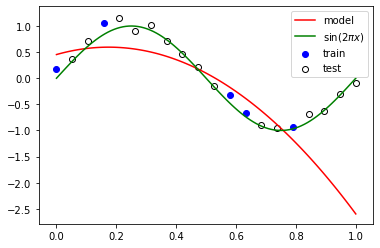

In [64]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

### Predecir y Evaluar

Para predecir, usamos la función **predict**:

In [65]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test) 

In [66]:
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)
print(f'Train error: {train_error:0.2}')
print(f'Test error: {test_error:0.2}')

Train error: 0.091
Test error: 0.87


Vemos que el Train error mejoro con respecto al primer modelo pero, subio considerablemente el Test train, dado que una parabola es muy mala para predecir algo que tiene una parte que baja y una que sube.  

## Sobreajuste vs. Generalización

Probaremos polinomios de varios grados, obteniendo valores de error en entrenamiento y evaluación:

In [90]:
train_errors = []
test_errors = []
degrees = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16,17,18,19,20,21,22,23,38]
for degree in degrees:
    # train:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)

Graficaremos las curvas de error en términos del grado del polinomio.

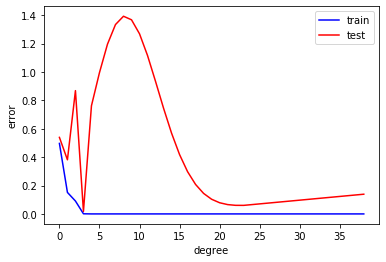

In [91]:
plt.plot(degrees, train_errors, color="blue", label="train")
plt.plot(degrees, test_errors, color="red", label="test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("error")
plt.show()

Se puede ver que el error en entrenamiento siempre baja, pero que en algún punto comienza el sobreajuste, ya que el error en evaluación empieza a subir.

### Mejor Modelo

De acuerdo a la gráfica anterior, y como era de esperarse, el modelo que mejor ajusta los datos es el de grado 3:

In [73]:
degree = 3
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train);

Graficamos:

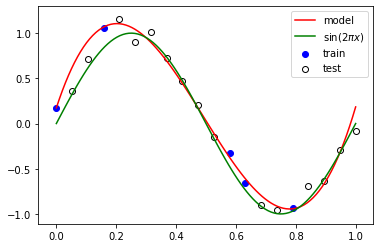

In [74]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

### Modelo Sobreajustado

Veamos cómo es la gráfica de uno de los modelos que sufre de sobreajuste:

In [83]:
degree = 8
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train);

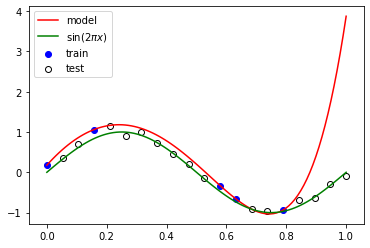

In [84]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.plot(x, model.predict(x.reshape(-1, 1)), color="red", label="model")
plt.plot(x, f_x, color="green", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

In [89]:
model.predict(np.array([[1.9]]))

array([621.72562585])

El modelo que uno aprende esta tratando de representar lo mejor posible a los datos de entraada.

## Ejercicios

1. Probar agregando puntos a los datos de entrenamiento para prevenir el sobreajuste en polinomios de grado alto.
2. Probar usando regularización para prevenir el sobreajuste en polinomios de grado alto
(ver [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)).

## Referencias

Scikit-learn:

- [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
- [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
